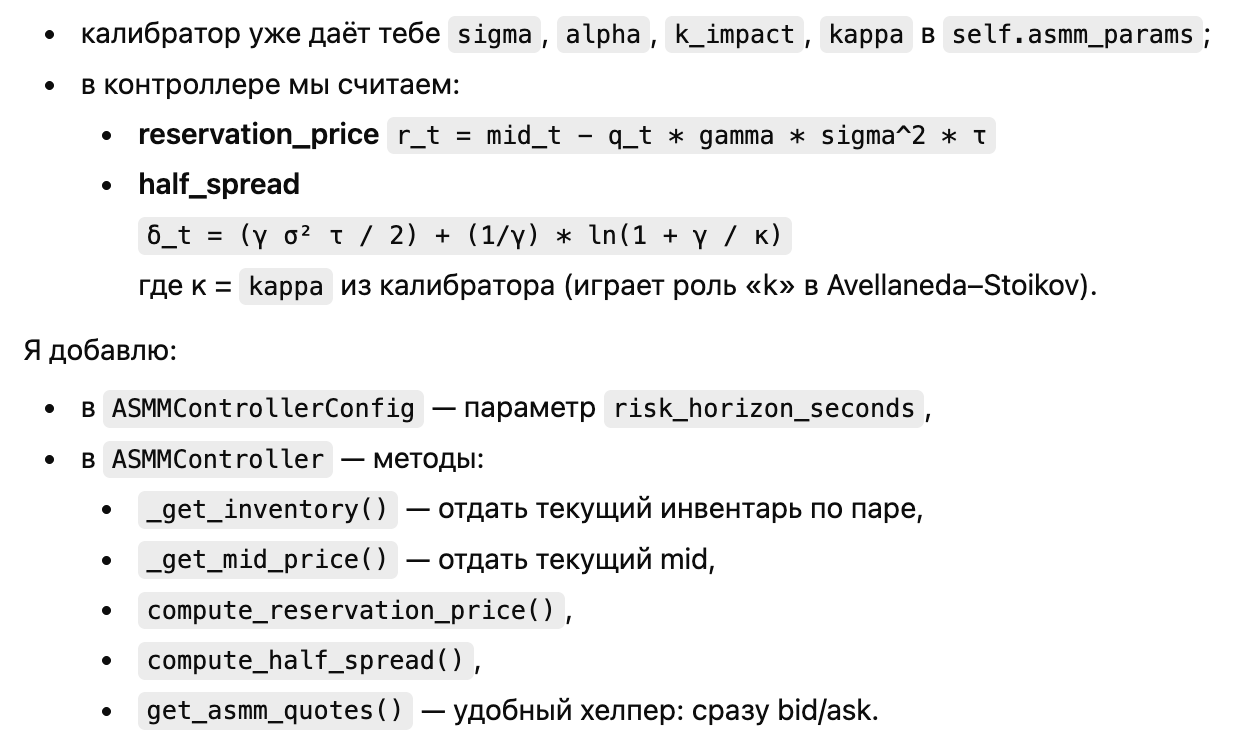

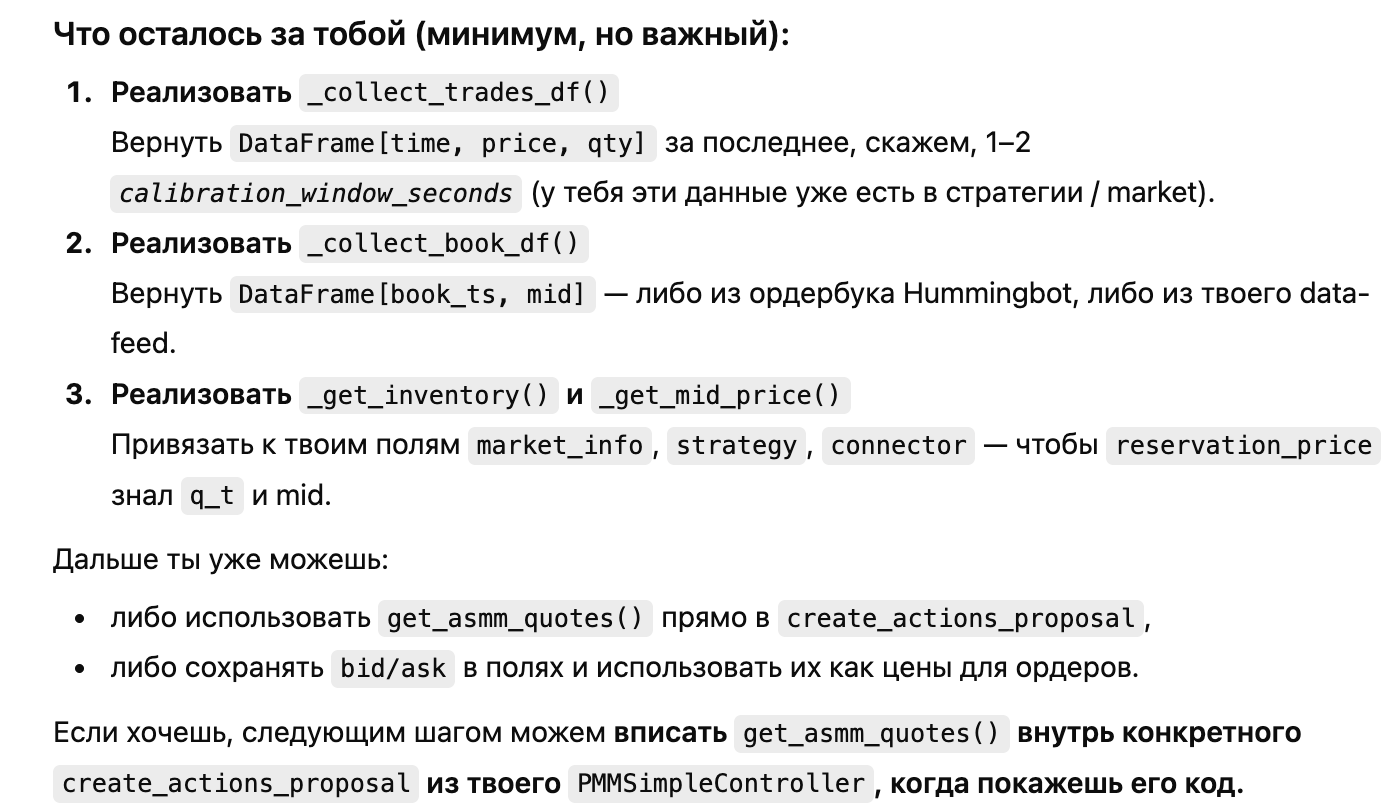

In [ ]:
from decimal import Decimal
from typing import List, Optional

import math
import pandas as pd
from pydantic import Field

from hummingbot.data_feed.candles_feed.data_types import CandlesConfig
from controllers.market_making.pmm_simple import PMMSimpleConfig, PMMSimpleController

from .asmm_calibrator import ASMMCalibrator, ASMMCalibrationResult


class ASMMControllerConfig(PMMSimpleConfig):
    # важно: новое имя контроллера для YAML и резолвинга
    controller_name: str = "asmm_controller"

    # риск-аверсия в ASMM (константа)
    gamma: float = 0.5

    # --- параметры сегмента объёмов для калибратора ---
    q0: float = 0.001        # нижний порог объёма (твой сегмент)
    q1: float = 0.1          # верхний порог объёма

    # --- окно и периодичность калибровки ---
    calibration_window_seconds: int = 900    # длина окна калибровки (последние N секунд)
    calibration_interval_seconds: int = 300  # как часто перезапускать калибровку
    min_trades_segment: int = 200            # минимум сделок в сегменте

    # --- риск-горизонт τ в секундах для формул ASMM ---
    risk_horizon_seconds: float = 60.0       # τ (например, 1 минута)

    # параметры свечей для MarketDataProvider (через config.candles_config)
    candles_connector_name: str = Field(default="binance")
    candles_interval: str = Field(default="1m")
    candles_length: int = Field(default=30)


class ASMMController(PMMSimpleController):
    def __init__(self, config: ASMMControllerConfig, *args, **kwargs):
        # Подготовим свечи через config — их поднимет MarketDataProvider
        if len(config.candles_config) == 0:
            config.candles_config = [
                CandlesConfig(
                    connector=config.candles_connector_name,
                    trading_pair=config.trading_pair,
                    interval=config.candles_interval,
                )
            ]

        super().__init__(config, *args, **kwargs)
        self.config: ASMMControllerConfig = config

        # --- калибратор ASMM ---
        self._calibrator = ASMMCalibrator(
            window_seconds=config.calibration_window_seconds,
            min_trades_segment=config.min_trades_segment,
            book_resample_rule="200ms",
            verbose=True,
        )
        self._last_calibration_ts: float = 0.0
        self._asmm_result: Optional[ASMMCalibrationResult] = None

    # ================== PUBLIC API ==================
    @property
    def asmm_params(self) -> Optional[ASMMCalibrationResult]:
        """
        Последние откалиброванные параметры σ, α, k, κ.
        Их используем в reservation_price и half_spread.
        """
        return self._asmm_result

    # ================== КАЛИБРОВКА ==================
    def _maybe_run_calibration(self, now_ts: float):
        """
        Периодически запускает калибровку, используя данные Hummingbot.
        """
        if now_ts - self._last_calibration_ts < self.config.calibration_interval_seconds:
            return

        trades_df = self._collect_trades_df()
        book_df = self._collect_book_df()

        if trades_df is None or trades_df.empty:
            self.logger().warning("ASMM: нет trades для калибровки.")
            return
        if book_df is None or book_df.empty:
            self.logger().warning("ASMM: нет book для калибровки.")
            return

        result = self._calibrator.calibrate(
            trades=trades_df,
            book=book_df,
            q0=self.config.q0,
            q1=self.config.q1,
        )

        if result is not None:
            self._asmm_result = result
            self._last_calibration_ts = now_ts
            self.logger().info(
                f"ASMM calibration updated: "
                f"sigma={result.sigma:.4g}, alpha={result.alpha:.4g}, "
                f"k={result.k_impact:.4g}, kappa={result.kappa:.4g}"
            )

    def _collect_trades_df(self) -> Optional[pd.DataFrame]:
        """
        TODO: привязать к конкретной реализации Hummingbot.

        Нужно вернуть DataFrame с колонками:
          - time (pd.Timestamp, tz-aware),
          - price (float),
          - qty (float).
        """
        raise NotImplementedError("ASMMController._collect_trades_df нужно реализовать под твой пайплайн.")

    def _collect_book_df(self) -> Optional[pd.DataFrame]:
        """
        TODO: привязать к конкретной реализации Hummingbot.

        Нужно вернуть DataFrame с колонками:
          - book_ts (pd.Timestamp, tz-aware),
          - mid (float).
        """
        raise NotImplementedError("ASMMController._collect_book_df нужно реализовать под твой пайплайн.")

    def _get_inventory(self) -> float:
        """
        Текущий инвентарь по базовой валюте.

        TODO: здесь надо привязаться к твоему способу хранения позиции:
          - через self._market_info,
          - через strategy position,
          - или через balances.
        Сейчас просто NotImplemented, чтобы явно не врать.
        """
        raise NotImplementedError("ASMMController._get_inventory нужно реализовать (вернуть q_t).")

    def _get_mid_price(self) -> Optional[float]:
        """
        Текущий mid по торговой паре.
        Можно брать best_bid/best_ask из market_info.

        TODO: привязать к твоему источнику.
        """
        # пример псевдокода:
        # mi = self.market_info  # или self._market_info
        # best_bid = mi.get_price(True)
        # best_ask = mi.get_price(False)
        # return float(0.5 * (best_bid + best_ask))
        raise NotImplementedError("ASMMController._get_mid_price нужно реализовать.")

    # ================== ASMM: reservation_price и half_spread ==================
    def compute_reservation_price(self) -> Optional[float]:
        # r_t = mid_t - q_t * gamma * sigma^2 * tau
        params = self.asmm_params
        if params is None:
            self.logger().warning("ASMM: нет asmm_params для reservation_price.")
            return None

        mid = self._get_mid_price()
        if mid is None:
            self.logger().warning("ASMM: нет mid для reservation_price.")
            return None

        q = self._get_inventory()
        gamma = float(self.config.gamma)
        tau = float(self.config.risk_horizon_seconds)
        sigma = float(params.sigma)

        if gamma <= 0 or tau <= 0 or sigma <= 0:
            return float(mid)

        sigma2 = sigma * sigma
        r_t = float(mid) - q * gamma * sigma2 * tau
        return r_t


    def compute_half_spread(self) -> Optional[float]:
        """
        δ = 1/γ * ln(1 + γ/kappa)
        (AS 2008, eq. 3.11–3.12: спред не зависит от σ и q)
        """
        params = self.asmm_params
        if params is None:
            self.logger().warning("ASMM: нет asmm_params для half_spread.")
            return None

        gamma = float(self.config.gamma)
        kappa = float(params.kappa)  # k из Avellaneda–Stoikov

        if gamma <= 0 or kappa <= 0:
            self.logger().warning("ASMM: некорректные параметры для half_spread.")
            return None

        delta_t = (1.0 / gamma) * math.log(1.0 + gamma / kappa)
        return float(delta_t)


    def get_asmm_quotes(self) -> Optional[tuple[float, float]]:
        """
        Удобный хелпер: вернуть (bid, ask) по ASMM.

        bid_t = r_t - δ_t
        ask_t = r_t + δ_t
        """
        r_t = self.compute_reservation_price()
        delta_t = self.compute_half_spread()

        if r_t is None or delta_t is None:
            self.logger().warning("ASMM: не удалось получить r_t или delta_t.")
            return None

        bid = r_t - delta_t
        ask = r_t + delta_t
        return float(bid), float(ask)

    # ================== OVERRIDES / интеграция с PMMSimple ==================
    def update_processed_data(self):
        """
        Пример, куда можно вкрутить калибровку и обновление параметров.
        """
        # базовая обработка PMMSimple
        super().update_processed_data()

        # дергаем калибратор
        try:
            now_ts = self._clock.timestamp  # в Hummingbot обычно так
        except Exception:
            now_ts = 0.0

        self._maybe_run_calibration(now_ts)

        # здесь же можно сохранить quotes для дальнейшего использования
        try:
            quotes = self.get_asmm_quotes()
            if quotes is not None:
                bid, ask = quotes
                # дальше можешь:
                #  - либо сохранить в self._current_bid/ask,
                #  - либо прокинуть в create_actions_proposal, если он это читает.
                self.logger().debug(f"ASMM quotes: bid={bid}, ask={ask}")
        except Exception as e:
            self.logger().warning(f"ASMM: ошибка при расчёте котировок: {e}")
